# Imports

In [1]:
import numpy as np
import pandas as pd
import glob
import gensim
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from random import sample, seed
from scipy import stats
import matplotlib.pyplot as plt
import stopwordsiso as stopwords
from nltk.wsd import lesk


# Set random seed
RANDOM_STATE = 3
seed(RANDOM_STATE)

# Notes

We use Principal Component Analysis (PCA) to reduce the embedding dimensionality and extract features that are relevant to the cluster structure.
PCA constructs a set of uncorrelated directions, or "components," that are ordered by their variance.
Previous work has shown that removing features with low variance using PCA provides a filter that
results in a more robust clustering, i.e. clusters with clearer structure that are less sensitive to noise.

In [2]:
def get_df_from_path(path):
    '''
    Concatenate all CSV files in the specified path and return
    the result as a DataFrame.

    @param path (str): path to input CSV files
    @return (DataFrame): DataFrame containing all data
    '''
  
    all_files = glob.glob(path)

    # Concatenate all CSVs in the specified path into one DataFrame
    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None, header=0)
        li.append(df)

    if li == []:
        return None

    df = pd.concat(li, axis=0, ignore_index=True)
    return df

In [3]:
# Load Google's pre-trained Word2Vec model
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(
    './GoogleNews-vectors-negative300.bin', binary=True)

In [4]:
# Get DataFrame of samples
samples = get_df_from_path('csv/*/*_comp.csv')

# Ensure words are not a stopword and present in Google's Word2Vec dictionary
def filter_fn(row):
    return row['Complement Lemma'] not in stopwords.stopwords("en") and row['Complement Lemma'] in word2vec_model

# Apply filter to samples DataFrame
m = samples.apply(filter_fn, axis=1)
samples = samples[m]

# Get synsets for WordNet analysis
samples['Complement Synset'] = samples.apply(
    lambda row: lesk(row['Sentence Text'], row['Complement Lemma'], 'n'), axis=1)

# Shuffle samples
samples = samples.sample(frac=1, random_state=RANDOM_STATE)

# Get the list of complements
words = list(samples['Complement Lemma'])

# Get the list of synsets
word_synsets = list(samples['Complement Synset'])

# Get vectors for complements
complement_vectors = word2vec_model[words]
print(complement_vectors.shape)

(493, 300)


In [5]:
samples

,Verb,Complement Category,Complement Lemma,Sentence Text,Complement Synset
233,make,NOUN,announcement,"In this case, following the talent leads me to...",Synset('announcement.n.02')
267,make,NOUN,mold,Make a mold.,Synset('mold.n.07')
587,make,NOUN,love,"On their wedding night, at the Hotel Ra-Ra (dé...",Synset('love.n.05')
539,make,NOUN,deal,"""So let us make a deal.",Synset('hand.n.06')
390,make,NOUN,candy,We had a great time and visited a location whe...,Synset('candy.n.01')
...,...,...,...,...,...
525,make,NOUN,list,I was at the age of making lists but the lists...,Synset('tilt.n.04')
153,make,NOUN,visit,"In his career, Dvořák made nine invited visits...",Synset('visit.n.04')
301,make,NOUN,advance,"In a statement issued June 16, 2004, the 9/11 ...",Synset('progress.n.03')
180,make,NOUN,flight,hi i 'm calling from boston i 'd like to make ...,Synset('flight.n.09')


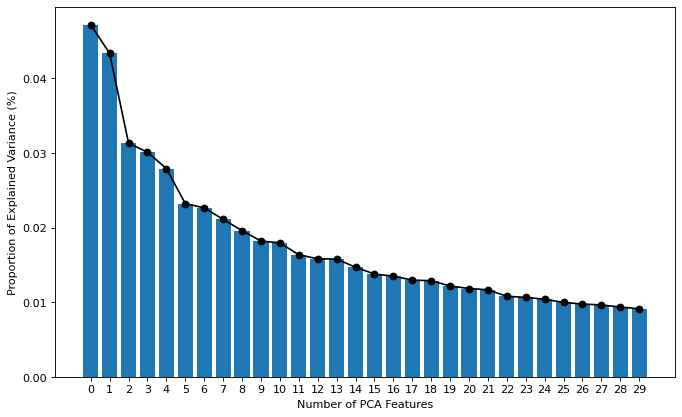

In [6]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import figure

figure(figsize=(10, 6), dpi=80)

# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(complement_vectors)
# Create a PCA instance: pca
pca = PCA(n_components=30, random_state=RANDOM_STATE)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_)
plt.plot(features, pca.explained_variance_ratio_, '-o', color='black')
plt.xlabel('Number of PCA Features')
plt.ylabel('Proportion of Explained Variance (%)')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

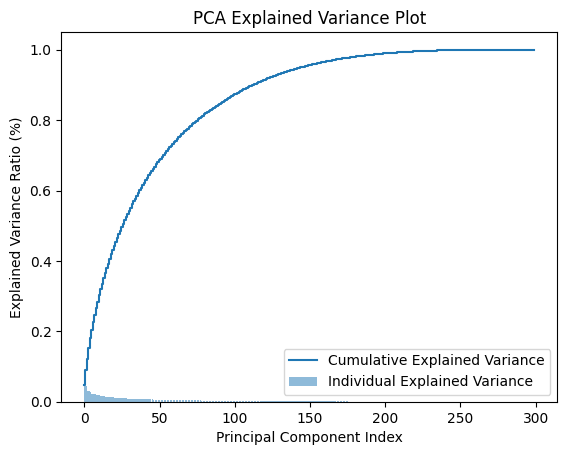

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(complement_vectors)
X_train_std = sc.transform(complement_vectors)

# Instantiate PCA
pca = PCA()

# Determine transformed features
X_train_pca = pca.fit_transform(X_train_std)

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual Explained Variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio (%)')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.title('PCA Explained Variance Plot')
plt.savefig('figures/pca-variance.pdf') 
plt.show()

In [8]:
# Based on this chart, let's use 150 PCA features
N_PCA = 150

# Let's observe the components
PCA_components

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,4.525518,-6.157015,-6.205713,1.027416,0.446198,-0.524042,3.507037,0.597262,0.369177,0.604614,...,0.789889,0.633003,-1.471380,2.543737,1.307341,0.036491,-0.252270,0.097160,-1.341018,0.278690
1,-4.766102,1.727788,0.942100,1.380469,-0.149569,2.834507,2.132326,-1.124315,-3.457463,0.462141,...,-0.992085,-2.659328,-0.407227,-1.115268,3.780900,3.934521,2.603667,-3.304467,1.248422,-1.891217
2,-3.026870,2.954236,2.017883,-0.837549,1.964261,-0.739639,-3.766027,-0.636998,3.688865,-0.173050,...,1.693013,0.950157,0.194296,-1.186625,1.821599,-3.240357,-2.068980,-0.108533,3.119041,0.848506
3,0.728553,-2.275097,-2.510286,-0.856988,-1.730411,2.006110,-2.187927,0.973657,-0.892111,0.321181,...,0.244329,3.120244,0.853338,0.473393,-0.144893,0.556279,1.375342,2.566396,-1.710255,-1.114944
4,-4.067837,5.680922,1.820363,-2.449241,0.994245,-0.177521,3.449836,3.882110,1.352282,0.371435,...,-0.593377,0.962421,-0.600666,0.854208,-1.465051,-0.912428,-1.794788,-0.136397,-1.818533,-2.817951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,-0.114550,1.573450,-5.260096,-1.131552,-2.369351,1.754322,0.143522,-0.180651,-2.945132,9.040003,...,4.216907,1.026436,2.269648,-2.267751,2.622432,1.839824,0.721572,-2.561193,1.735966,1.640521
489,9.723440,3.304936,-2.095996,1.115572,-1.490444,-1.704754,0.322201,0.408157,0.186788,1.690928,...,1.006098,-0.779563,-0.346342,1.151595,0.874996,-1.001252,0.695185,-1.479798,0.141344,-2.976395
490,1.491579,-1.157152,0.974410,-1.065202,-3.001624,1.712127,0.053698,0.424738,-0.483134,0.825366,...,0.197577,-1.653385,-2.347376,0.177864,-0.303318,-0.879866,0.304766,1.444902,1.330220,-0.091356
491,6.328710,3.973447,2.163117,2.140464,-1.420337,-0.989336,0.338520,-2.338858,-2.285526,-1.142884,...,1.210127,-2.702484,-1.820529,-1.039325,6.727589,-1.451031,-2.628409,4.477113,0.026474,0.948008


Text(0, 0.5, 'PCA 2')

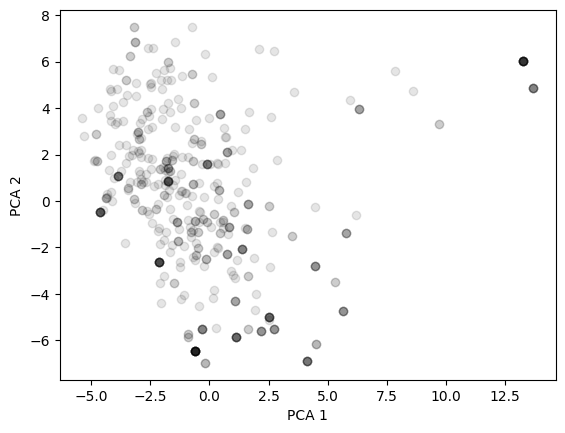

In [9]:
# View scatterplot of the first two components
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

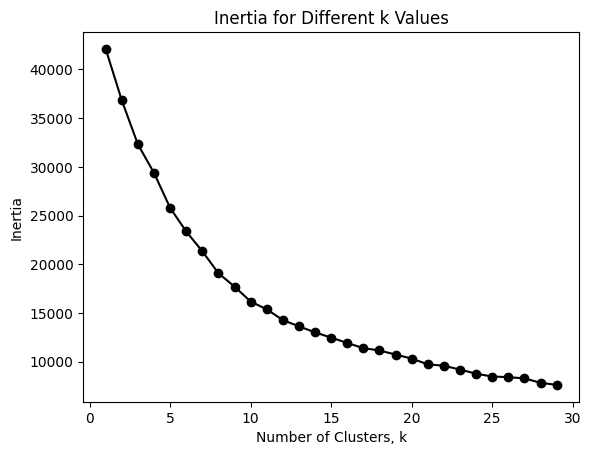

In [10]:
from matplotlib.pyplot import figure

ks = range(1, 30)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans_model = KMeans(n_clusters=k)
    
    # Fit model to samples
    kmeans_model.fit(PCA_components.iloc[:,:10])
    
    # Append the inertia to the list of inertias
    inertias.append(kmeans_model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.title('Inertia for Different k Values')
plt.savefig('figures/kmeans-inertia.pdf') 
# plt.xticks(ks)
plt.show()

In [11]:
# Based on this chart, let's use 15 clusters
N_CLUSTERS = 15

In [12]:
# Fit K-means model with clusters to the complement vectors after PCA
kmeans_model = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE).fit(PCA_components.iloc[:,:N_PCA])

# Obtain mapping from cluster numbers to the words and synsets contained within them
cluster_to_word_list = defaultdict(list)
cluster_to_syns_list = defaultdict(list)
for w, c in enumerate(kmeans_model.labels_):
    cluster_to_word_list[c].append(words[w])
    cluster_to_syns_list[c].append(word_synsets[w])

# Number of words in cluster to sample for observation
sample_size = 10
all_sample_words = []

data = []

for i, centroid in enumerate(kmeans_model.cluster_centers_):

    # Get all the words in the cluster as a list
    words_in_cluster = list(cluster_to_word_list[i])
    cluster_word_count = len(words_in_cluster)
    unique_words_in_cluster = list(set(words_in_cluster))

    # Get synsets in cluster
    syns_in_cluster = list(cluster_to_syns_list[i])

    # Get a sample of words in the cluster
    if len(unique_words_in_cluster) < sample_size:
        sample_words = words_in_cluster.copy()
    else:
        sample_words = sample(words_in_cluster,
                              k=sample_size)

    all_sample_words.extend(sample_words)

    # Append to data
    data.append([cluster_word_count, set(sample_words), unique_words_in_cluster, syns_in_cluster]) # list(centroid_words), sample_words])

In [13]:
# Make DataFrame
df = pd.DataFrame(data, columns=['Cluster Word Count', 'Sample Words', 'All Words', 'All Synsets'])# 'Centroid Words', 'Sample Words'])
df.to_csv('clusters-pca-no-filter.csv')
df

,Cluster Word Count,Sample Words,All Words,All Synsets
0,22,"{snitch, friend, life, woman, love, girl, cat}","[snitch, kid, child, friend, life, love, girl,...","[Synset('love.n.05'), Synset('sawhorse.n.01'),..."
1,144,"{concern, living, wave, nightlife, connection,...","[bounce, demand, fringe, presentation, sale, r...","[Synset('reservation.n.06'), Synset('sidereal_..."
2,24,"{adjustment, alteration, modification, change,...","[adjustment, alteration, modification, change,...","[Synset('variety.n.06'), Synset('variety.n.06'..."
3,114,"{distinction, statue, word, cover, fool, breas...","[pattern, toy, substance, cover, image, scribb...","[Synset('mold.n.07'), Synset('jester.n.01'), S..."
4,4,{comment},[comment],"[Synset('remark.n.01'), Synset('remark.n.01'),..."
5,25,"{pilgrimage, trip, visit, travel, tour, stopover}","[pilgrimage, trip, visit, travel, tour, stopover]","[Synset('tripper.n.04'), Synset('stopover.n.01..."
6,9,{noise},[noise],"[Synset('noise.n.04'), Synset('noise.n.04'), S..."
7,30,"{vodka, soup, bowl, food, candy, cactus, wine,...","[sandwich, food, chicken, cake, lunch, cupcake...","[Synset('candy.n.01'), Synset('bottle.n.03'), ..."
8,21,"{proposal, decision, conclusion, request, amen...","[proposal, decision, conclusion, request, amen...","[Synset('date.n.03'), Synset('amendment.n.02')..."
9,11,"{error, blunder, mistake}","[error, blunder, mistake]","[Synset('mistake.n.01'), Synset('mistake.n.01'..."


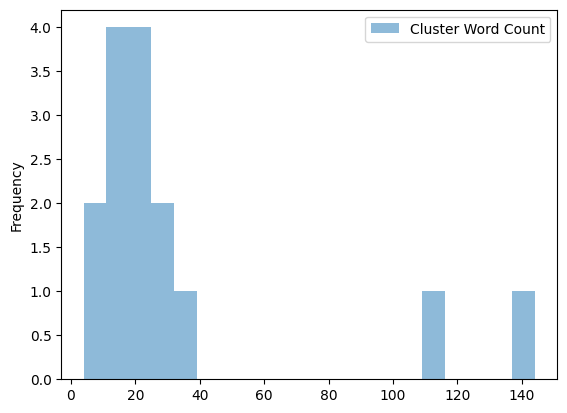

In [14]:
# Let's visualize the cluster size distribution
ax = df.plot.hist(bins=20, alpha=0.5)

In [15]:
# Since the distribution is not Gaussian, we just use quantiles
# for outlier removal

q_low = df['Cluster Word Count'].quantile(0.05)
q_hi = df['Cluster Word Count'].quantile(0.95)

df_filtered = df[(df['Cluster Word Count'] < q_hi) &
                 (df['Cluster Word Count'] > q_low)]
print('New number of clusters:', len(df_filtered))

pd.set_option('display.max_colwidth', None)
df.to_csv('clusters-pca-filter.csv')
df_filtered


New number of clusters: 13


,Cluster Word Count,Sample Words,All Words,All Synsets
0,22,"{snitch, friend, life, woman, love, girl, cat}","[snitch, kid, child, friend, life, love, girl, mother, woman, cat, horse, pet]","[Synset('love.n.05'), Synset('sawhorse.n.01'), Synset('supporter.n.01'), Synset('life_sentence.n.01'), Synset('life_sentence.n.01'), Synset('supporter.n.01'), Synset('sawhorse.n.01'), Synset('love.n.05'), Synset('mother.n.05'), Synset('girlfriend.n.02'), Synset('mother.n.05'), Synset('kat.n.01'), Synset('positron_emission_tomography.n.01'), Synset('love.n.05'), Synset('kid.n.02'), Synset('life_sentence.n.01'), Synset('fink.n.01'), Synset('womanhood.n.02'), Synset('supporter.n.01'), Synset('supporter.n.01'), Synset('child.n.04'), Synset('fink.n.01')]"
2,24,"{adjustment, alteration, modification, change, revision}","[adjustment, alteration, modification, change, revision]","[Synset('variety.n.06'), Synset('variety.n.06'), Synset('variety.n.06'), Synset('alteration.n.02'), Synset('variety.n.06'), Synset('variety.n.06'), Synset('variety.n.06'), Synset('rewrite.n.01'), Synset('rewrite.n.01'), Synset('alteration.n.02'), Synset('variety.n.06'), Synset('alteration.n.02'), Synset('variety.n.06'), Synset('variety.n.06'), Synset('variety.n.06'), Synset('variety.n.06'), Synset('variety.n.06'), Synset('variety.n.06'), Synset('variety.n.06'), Synset('variety.n.06'), Synset('alteration.n.02'), Synset('variety.n.06'), Synset('modification.n.03'), Synset('variety.n.06')]"
3,114,"{distinction, statue, word, cover, fool, breast, comparison, sculpture, item}","[pattern, toy, substance, cover, image, scribble, password, figure, reference, impression, gift, exception, mention, film, chatter, breast, sculpture, sample, headline, brick, statue, word, guess, picture, leaf, fool, excuse, list, adaptation, writing, annotation, glance, money, sound, technique, jab, comparison, glowstick, bit, version, mischief, message, item, wai, note, grimace, convo, meaning, lot, repellent, bet, brack, wallpaper, pin, poster, language, distinction, grammar, buck, bird, horseshoe, type, mop, material, joke, scent, lyric, cloth, journal, mold, shadow, hair, shoe, box]","[Synset('mold.n.07'), Synset('jester.n.01'), Synset('lyric.n.02'), Synset('stamp.n.03'), Synset('leaf.n.03'), Synset('swab.n.02'), Synset('pivot.n.02'), Synset('mention.n.01'), Synset('substance.n.07'), Synset('excuse.n.02'), Synset('material.n.05'), Synset('lot.n.02'), Synset('money.n.03'), Synset('note.n.09'), Synset('chatter.n.02'), Synset('glance.n.01'), Synset('joke.n.04'), Synset('movie.n.01'), Synset('trope.n.01'), Synset('comparison.n.03'), Synset('tilt.n.04'), Synset('joke.n.04'), Synset('comparison.n.03'), None, Synset('terminology.n.01'), Synset('version.n.06'), Synset('stamp.n.03'), Synset('trope.n.01'), Synset('giving.n.01'), Synset('sculpture.n.01'), Synset('sample_distribution.n.01'), Synset('horseshoe.n.02'), None, Synset('adaptation.n.03'), Synset('word.n.07'), Synset('guess.n.01'), Synset('mischief.n.01'), Synset('strait.n.01'), Synset('writing.n.04'), Synset('message.n.02'), Synset('meaning.n.02'), Synset('corner.n.08'), Synset('money.n.03'), Synset('adaptation.n.03'), None, Synset('word.n.07'), Synset('movie.n.01'), Synset('tilt.n.04'), Synset('adaptation.n.03'), Synset('token.n.01'), Synset('scent.n.02'), Synset('stamp.n.03'), Synset('type.n.06'), Synset('fabric.n.01'), Synset('shuttlecock.n.01'), Synset('money.n.03'), Synset('word.n.07'), Synset('note.n.07'), Synset('reference_book.n.01'), Synset('wallpaper.n.01'), Synset('word.n.07'), Synset('brick.n.02'), Synset('money.n.03'), Synset('radiation_pattern.n.01'), Synset('tail.n.05'), Synset('word_picture.n.01'), Synset('word.n.07'), Synset('tilt.n.04'), Synset('reference_book.n.01'), Synset('joke.n.04'), Synset('money.n.03'), Synset('stake.n.04'), Synset('headline.n.01'), Synset('guess.n.01'), Synset('journal.n.05'), Synset('word.n.07'), Synset('strait.n.01'), Synset('poster.n.01'), Synset('hair.n.06'), Synset('statue.n.01'), Synset('technique.n.

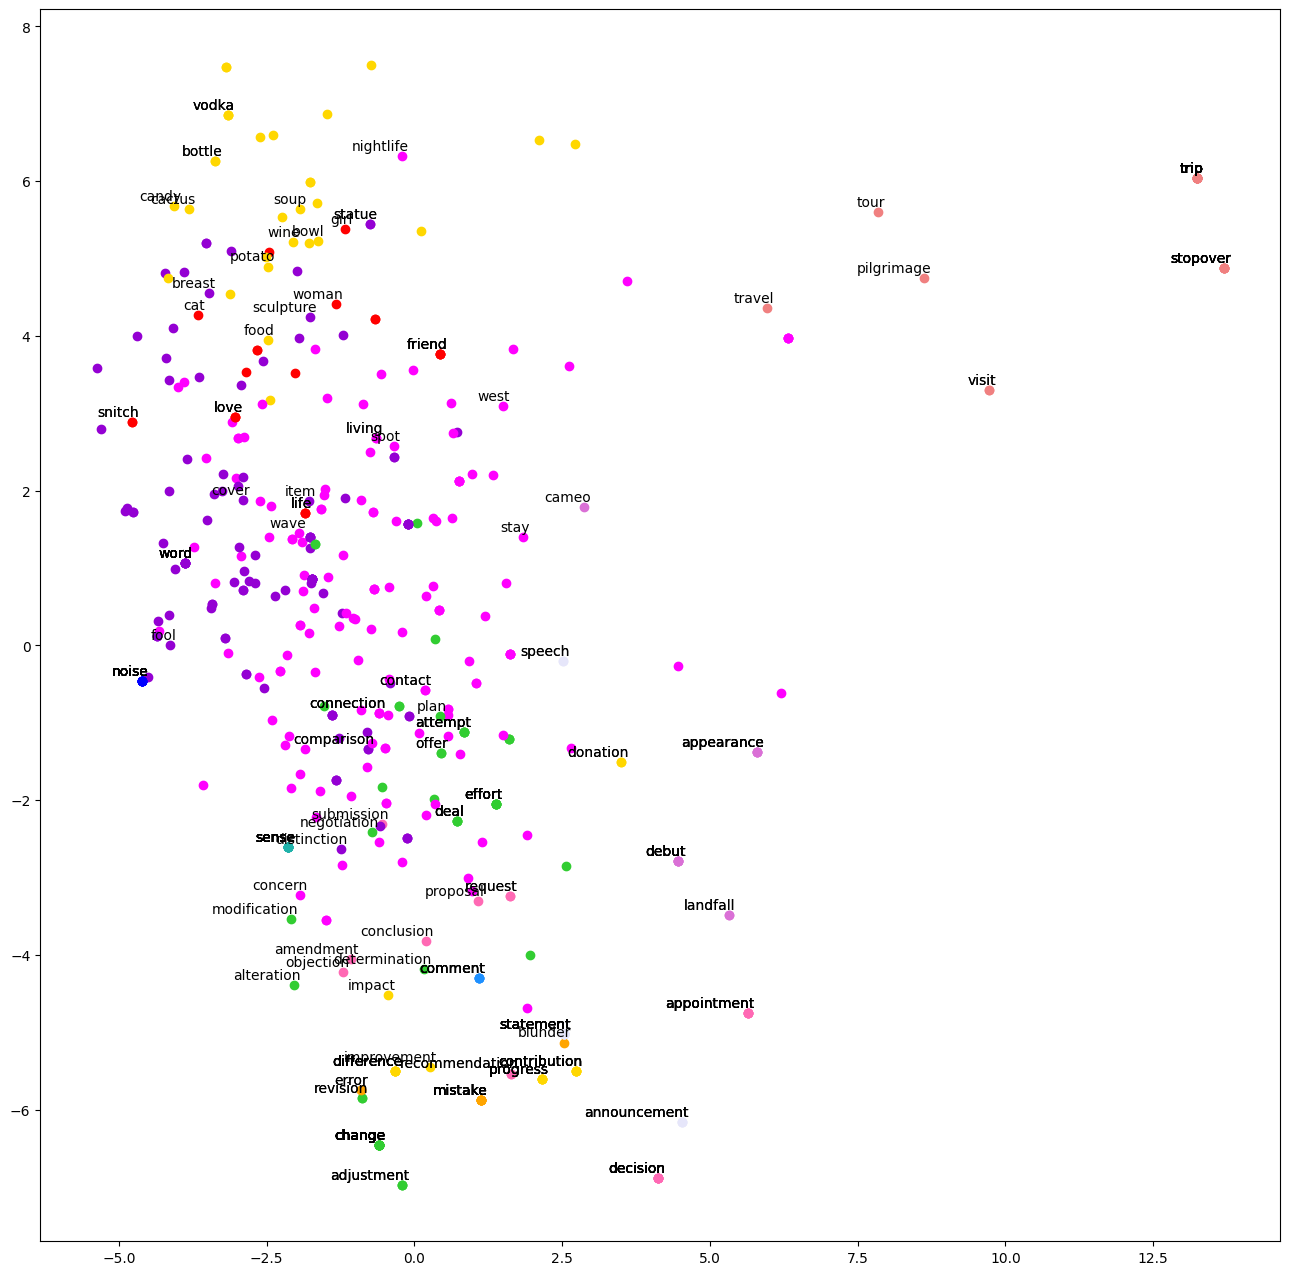

In [16]:
color_map = {
    0: 'red',
    1: 'magenta',
    2: 'limegreen',
    3: 'darkviolet',
    4: 'dodgerblue',
    5: 'lightcoral',
    6: 'blue',
    7: 'gold',
    8: 'hotpink',
    9: 'orange',
    10: 'limegreen',
    11: 'orchid',
    12: 'lavender',
    13: 'lightseagreen',
    14: 'gold',
}

x = PCA_components[0]
y = PCA_components[1]

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i], c=color_map[kmeans_model.labels_[i]])

    if words[i] in all_sample_words:
        plt.annotate(words[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom')
plt.show()

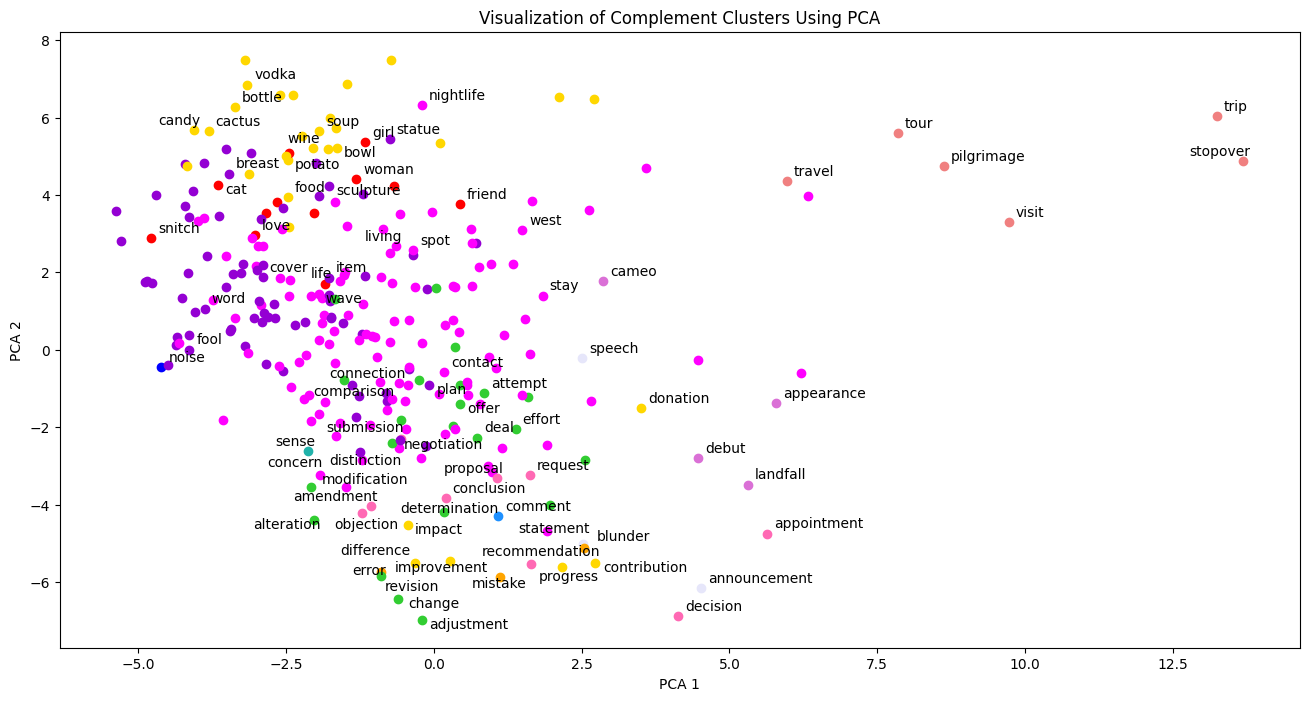

In [17]:
# Display a more readable plot
all_sample_words = list(set(all_sample_words))

words_index = {}
for i, word in enumerate(words):
    words_index[word] = i

indices = list(words_index.values())

words_new =[words[i] for i in indices]

z = list(zip(PCA_components[0], PCA_components[1]))
z_filtered = [z[i] for i in indices]
x, y = list(zip(*z_filtered))
labels_filtered = [kmeans_model.labels_[i] for i in indices]

texts = []
plt.figure(figsize=(16, 8)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i], c=color_map[labels_filtered[i]])

    if words_new[i] in all_sample_words:
        texts.append(plt.annotate(words_new[i],
                    xy=(x[i], y[i]),
                    xytext=(5, 2),
                    textcoords='offset points',
                    ha='right',
                    va='bottom'))

from adjustText import adjust_text
adjust_text(texts, only_move={'points':'y', 'texts':'y'})
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Visualization of Complement Clusters Using PCA') 
plt.savefig('figures/word-clusters.pdf') 
plt.show()


In [18]:
import itertools
from statistics import mean

# Get the average wu-palmer similarity of complements within a cluster
# And between clusters
similarities = np.zeros((N_CLUSTERS, N_CLUSTERS))

for i in range(15):
    for j in range(15):
        
        cluster_A = df['All Synsets'][i]
        cluster_B = df['All Synsets'][j]

        # Get cross product of cluster A with cluster B (shared_coordinations)
        cluster_pairs = list(itertools.product(cluster_A, cluster_B))

        wp_sim_cluster = []
        for syn1, syn2 in cluster_pairs:
            if syn1 is not None and syn2 is not None:
                wp_sim_cluster.append(syn1.wup_similarity(syn2))

        similarities[i][j] = mean(wp_sim_cluster) if len(
            wp_sim_cluster) > 0 else 0.0


In [19]:
from sklearn.preprocessing import normalize
norm_similarities = normalize(similarities, axis=1, norm='l1')

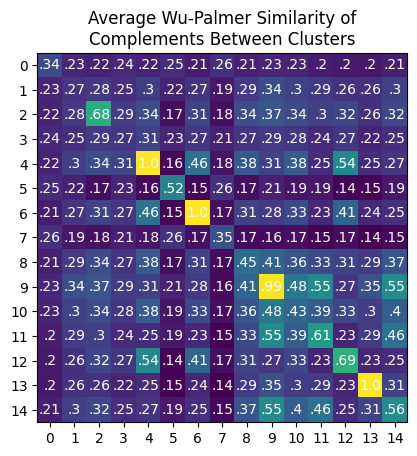

In [20]:
fig, ax = plt.subplots()
im = ax.imshow(similarities)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(N_CLUSTERS), labels=range(N_CLUSTERS))
ax.set_yticks(np.arange(N_CLUSTERS), labels=range(N_CLUSTERS))

# Loop over data dimensions and create text annotations.
for i in range(N_CLUSTERS):
    for j in range(N_CLUSTERS):
        text = ax.text(j, i, str(round(similarities[i, j], 2)).lstrip('0'),
                       ha="center", va="center", color="w")

ax.set_title("Average Wu-Palmer Similarity of\nComplements Between Clusters")
plt.savefig('figures/wu-palmer.pdf') 
plt.show()

In [21]:
print('Average similarity within clusters:', np.mean(similarities.diagonal()))
print('Average similarity between clusters:', \
  (np.sum(similarities) - np.sum(similarities.diagonal())) / \
    (N_CLUSTERS * N_CLUSTERS - N_CLUSTERS))

Average similarity within clusters: 0.6105284425946161
Average similarity between clusters: 0.2729861001773626


In [22]:
# Get DataFrame of samples
coordination = get_df_from_path('ccp_csv/*/*_ccps.csv')

cluster_A = df['All Words'][3]
cluster_B = df['All Words'][7]
print(cluster_A)
print(cluster_B)

import itertools

# Get cross product of cluster A with itself (coordinations within cluster A)
cluster_A_pairs = list(itertools.product(cluster_A, cluster_A))

# Get cross product of cluster B with itself (coordinations within cluster B)
cluster_B_pairs = list(itertools.product(cluster_B, cluster_B))

# Get cross product of cluster A with cluster B (shared_coordinations)
cluster_shared_pairs = list(itertools.product(
    cluster_A, cluster_B)) + list(itertools.product(cluster_B, cluster_A))

coordination_counts = defaultdict(int)

for index, row in coordination.iterrows():
    coord = (row['1st Conjunct Text'], row['2nd Conjunct Text'])
    coordination_counts[(row['1st Conjunct Text'], row['2nd Conjunct Text'])] += 1

cluster_A_coord_count = 0
for c in cluster_A_pairs:
    if c in coordination_counts:
        cluster_A_coord_count += coordination_counts[c]
        print(c)

cluster_B_coord_count = 0
for c in cluster_B_pairs:
    if c in coordination_counts:
        cluster_B_coord_count += coordination_counts[c]
        print(c)

cluster_shared_coord_count = 0
for c in cluster_shared_pairs:
    if c in coordination_counts:
        cluster_shared_coord_count += coordination_counts[c]
        print(c)

print(cluster_A_coord_count, cluster_B_coord_count, cluster_shared_coord_count)

['pattern', 'toy', 'substance', 'cover', 'image', 'scribble', 'password', 'figure', 'reference', 'impression', 'gift', 'exception', 'mention', 'film', 'chatter', 'breast', 'sculpture', 'sample', 'headline', 'brick', 'statue', 'word', 'guess', 'picture', 'leaf', 'fool', 'excuse', 'list', 'adaptation', 'writing', 'annotation', 'glance', 'money', 'sound', 'technique', 'jab', 'comparison', 'glowstick', 'bit', 'version', 'mischief', 'message', 'item', 'wai', 'note', 'grimace', 'convo', 'meaning', 'lot', 'repellent', 'bet', 'brack', 'wallpaper', 'pin', 'poster', 'language', 'distinction', 'grammar', 'buck', 'bird', 'horseshoe', 'type', 'mop', 'material', 'joke', 'scent', 'lyric', 'cloth', 'journal', 'mold', 'shadow', 'hair', 'shoe', 'box']
['sandwich', 'food', 'chicken', 'cake', 'lunch', 'cupcake', 'cheeseburger', 'packet', 'bowl', 'candy', 'dish', 'cocktail', 'omelette', 'pesto', 'pizza', 'vodka', 'soup', 'dinner', 'cactus', 'pie', 'cup', 'wine', 'potato', 'bottle', 'cream']
('image', 'word